Idea: Show the tradeoffs between explicitly depending on (+ profiling) and removing dependence on a given systematic uncertainty using the ideas from [1601.07913](https://arxiv.org/pdf/1601.07913.pdf) and [1611.01046](https://arxiv.org/pdf/1611.01046.pdf) (code is [here](https://github.com/glouppe/paper-learning-to-pivot/blob/master/code/Toy.ipynb)).

In [60]:
load_data = True

In [61]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

First, let's generate some toy data.  The data are "dijets" where mJJ is samples and then pT1 = pT2 = mJJ/2.  Then, we smear these "pTs" and recombine to give the reco mJJ.

In [62]:
def mymod(x,n=0.5):
    y = x
    while y < -n:
        y+=2*n
        pass
    while y > n:
        y-=2*n
    return y

(array([ 32177.,  33391.,  37146.,  42238.,  51127.,  64937.,  86551.,
        128767., 232254., 541451., 541281., 231961., 128586.,  86857.,
         64751.,  50859.,  42679.,  37069.,  33615.,  32303.]),
 array([-4.99997950e-01, -4.49998080e-01, -3.99998210e-01, -3.49998339e-01,
        -2.99998469e-01, -2.49998599e-01, -1.99998728e-01, -1.49998858e-01,
        -9.99989874e-02, -4.99991170e-02,  7.53358345e-07,  5.00006237e-02,
         1.00000494e-01,  1.50000364e-01,  2.00000235e-01,  2.50000105e-01,
         2.99999976e-01,  3.49999846e-01,  3.99999716e-01,  4.49999587e-01,
         4.99999457e-01]),
 <a list of 20 Patch objects>)

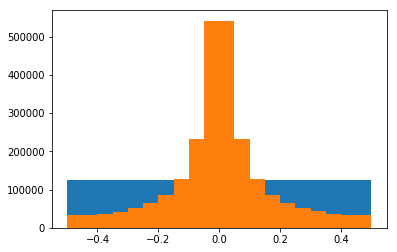

In [63]:
if (load_data):
    
    #Let's save to file so that we can skip this step in the future.
    signal_tot = np.load("signal_tot.txt.npy")
    background_tot = np.load("background_tot.txt.npy")
    signal_diff_tot = np.load("signal_diff_tot.txt.npy")
    background_diff_tot = np.load("background_diff_tot.txt.npy")
    pass
    
else:
    N = 500000
    sigmas = [0.02,0.04,0.08,0.16,0.32]

    signal_tot = []
    background_tot = []
    signals = []
    backgrounds = []

    signal_diff_tot = []
    background_diff_tot = []
    signals_diff = []
    backgrounds_diff = []

    for sigma in sigmas:
        print("on sigma",sigma)
        background=[]
        background_diff=[]
        for i in range(N):
            mJJtrue = np.random.uniform(0,1)-0.5
            pT1true = mJJtrue*0.5
            pT2true = mJJtrue*0.5
            pT1reco = mymod(np.random.normal(pT1true,sigma))
            pT2reco = mymod(np.random.normal(pT2true,sigma))
            mJJreco = mymod(pT1reco+pT2reco)
            delta = pT1reco-pT2reco
            background+=[mJJreco]
            backgrounds+=[mJJreco]
            background_diff+=[delta]
            backgrounds_diff+=[delta]
        background=list(zip(background,sigma*np.ones(len(background))))  
        background_diff=list(zip(background_diff,sigma*np.ones(len(background_diff))))  

        if (len(background_tot) > 0):
            background_tot = np.concatenate((background_tot,background))
            background_diff_tot = np.concatenate((background_diff_tot,background_diff))
        else:
            background_tot = background
            background_diff_tot = background_diff
            pass
        pass    

        signal=[]
        signal_diff=[]
        for i in range(N):
            mJJtrue = 0.0
            pT1true = mJJtrue*0.5
            pT2true = mJJtrue*0.5
            pT1reco = mymod(np.random.normal(pT1true,sigma))
            pT2reco = mymod(np.random.normal(pT2true,sigma))
            mJJreco = mymod(pT1reco+pT2reco)
            delta = pT1reco-pT2reco
            signal+=[mJJreco]
            signals+=[mJJreco]
            signal_diff+=[delta]
            signals_diff+=[delta]        
        signal=list(zip(signal,sigma*np.ones(len(signal)))) 
        signal_diff=list(zip(signal_diff,sigma*np.ones(len(signal_diff)))) 

        if (len(signal_tot) > 0):
            signal_tot = np.concatenate((signal_tot,signal))
            signal_diff_tot = np.concatenate((signal_diff_tot,signal_diff))
        else:
            signal_tot = signal
            signal_diff_tot = signal_diff
            pass
        pass    

        #plt.hist([background,signal],bins=20,stacked=True)
        #plt.hist(background,bins=20,stacked=True)
        #plt.hist(signal,bins=20,stacked=True)
    
    #Let's save to file so that we can skip this step in the future.
    np.save("signal_tot.txt", signal_tot)
    np.save("background_tot.txt", background_tot)
    np.save("signal_diff_tot.txt", signal_diff_tot)
    np.save("background_diff_tot.txt", background_diff_tot)    
    
plt.hist(backgrounds,bins=20,stacked=True)
plt.hist(signals,bins=20,stacked=True)

(array([  1467.,   4710.,   9267.,  15506.,  25407.,  40881.,  63942.,
        107768., 212000., 778354., 764474., 210187., 106382.,  63834.,
         40096.,  25506.,  15346.,   8991.,   4519.,   1363.]),
 array([-9.97933500e-01, -8.98075027e-01, -7.98216554e-01, -6.98358081e-01,
        -5.98499608e-01, -4.98641135e-01, -3.98782663e-01, -2.98924190e-01,
        -1.99065717e-01, -9.92072440e-02,  6.51228897e-04,  1.00509702e-01,
         2.00368175e-01,  3.00226647e-01,  4.00085120e-01,  4.99943593e-01,
         5.99802066e-01,  6.99660539e-01,  7.99519012e-01,  8.99377485e-01,
         9.99235957e-01]),
 <a list of 20 Patch objects>)

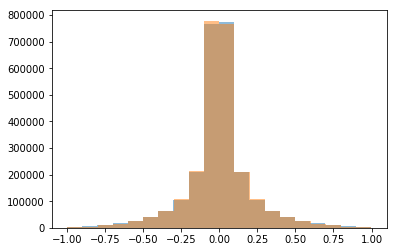

In [64]:
plt.hist(backgrounds_diff,bins=20,alpha=0.5)
plt.hist(signals_diff,bins=20,alpha=0.5)

Let's quickly make sure the plots look like we expect.

In [65]:
checkplot1=[x for (x,y) in background_diff_tot if y==0.32]
checkplot2=[x for (x,y) in background_diff_tot if y==0.02]

(array([2.90000e+01, 6.47000e+02, 9.08200e+03, 5.33910e+04, 1.42220e+05,
        1.72661e+05, 9.51780e+04, 2.38530e+04, 2.78500e+03, 1.54000e+02]),
 array([-0.13633748, -0.1103449 , -0.08435232, -0.05835974, -0.03236716,
        -0.00637459,  0.01961799,  0.04561057,  0.07160315,  0.09759573,
         0.12358831]),
 <a list of 10 Patch objects>)

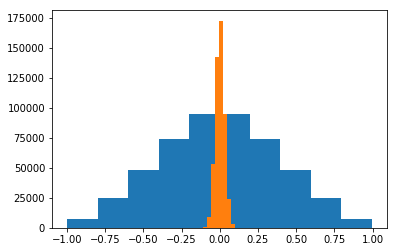

In [66]:
plt.hist(checkplot1)
plt.hist(checkplot2)

Now time to train some neural networks!

In [68]:
# create model
model = Sequential()
model.add(Dense(10, input_dim=2, activation='elu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='elu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [69]:
signal_labels = np.ones(len(signal_tot))
background_labels = np.zeros(len(background_tot))
X = np.concatenate((signal_tot, background_tot))
Y = np.concatenate((signal_labels, background_labels))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8)

In [70]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
# Fit the model
model.fit(X_train, Y_train, epochs=3, batch_size=50)

Epoch 1/3
1000000/1000000 [==============================] - 127s 127us/step - loss: 0.4970 - acc: 0.7222
Epoch 2/3
1000000/1000000 [==============================] - 127s 127us/step - loss: 0.4903 - acc: 0.7246
Epoch 3/3
1000000/1000000 [==============================] - 128s 128us/step - loss: 0.4873 - acc: 0.7261


In [74]:
model.save_weights("savedweights.h5")

In [75]:
model.load_weights("savedweights.h5")

Let's make sure it learned something sensible.

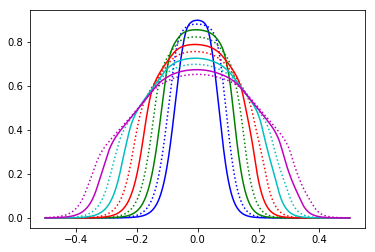

In [76]:
start =-0.5
xvals = []
while start < 0.5:
    xvals+=[start]
    start+=0.001
    pass
fig, ax = plt.subplots()
colors=['b','b','g','g','r','r','c','c','m','m']
sigmas = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11]
#sigmas = [0.02,0.03,0.04,0.06,0.08,0.12,0.16,0.24,0.32]
for i in range(len(sigmas)):
    xvals2 = list(zip(xvals,sigmas[i]*np.ones(len(xvals))))
    NNoutput = model.predict(np.array(xvals2))
    if (i%2==1):
        ax.plot(xvals, NNoutput,color=colors[i],linestyle=':')
    else:
        ax.plot(xvals, NNoutput,color=colors[i])
        pass
    pass

Now, let's compute the significance improvement from weighting every event by the NN output.

In [14]:
signal_nominal = [[x,y] for (x,y) in signal_tot if y==0.08]
signal_nominal_weights = model.predict(np.array(signal_nominal))
print("Done processing nominal signal")
background_nominal = [[x,y] for (x,y) in background_tot if y==0.08]
background_nominal_weights = model.predict(np.array(background_nominal))

Done processing nominal signal


In [106]:
#Now, we want to count.

In [15]:
sum(signal_nominal_weights)/sum(background_nominal_weights)

array([2.1020784], dtype=float32)

What if we train for the wrong (s1) and correct (s0) values of sigma?

In [39]:
sigmas = [0.02,0.04,0.08,0.16,0.32]
models_si = {}
for sigma in sigmas:
    models_si[sigma] = Sequential()
    models_si[sigma].add(Dense(10, input_dim=1, activation='elu'))
    models_si[sigma].add(Dropout(0.1))
    models_si[sigma].add(Dense(20, activation='elu'))
    models_si[sigma].add(Dropout(0.1))
    models_si[sigma].add(Dense(1, activation='sigmoid'))
    pass

In [40]:
signal_tot_si = {}
background_tot_si = {}
for sigma in sigmas:
    print(sigma)
    signal_tot_si[sigma]=np.array([[x] for (x,y) in signal_tot if y==sigma])
    background_tot_si[sigma]=np.array([[x] for (x,y) in background_tot if y==sigma])
    pass

0.02
0.04
0.08
0.16
0.32


In [43]:
X_train_si = {}
X_test_si = {}
Y_train_si = {}
Y_test_si = {}

for sigma in sigmas:

    signal_labels_si = np.ones(len(signal_tot_si[sigma]))
    background_labels_si = np.zeros(len(background_tot_si[sigma]))
    X_si = np.concatenate((signal_tot_si[sigma], background_tot_si[sigma]))
    Y_si = np.concatenate((signal_labels_si, background_labels_si))
    X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(X_si, Y_si, test_size=0.8)
    X_train_si[sigma] = X_train_s
    X_test_si[sigma] = X_test_s
    Y_train_si[sigma] = Y_train_s
    Y_test_si[sigma] = Y_test_s
    pass

In [45]:
for sigma in sigmas:
    models_si[sigma].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    pass

In [46]:
for sigma in sigmas:
    print("on sigma = ",sigma)
    models_si[sigma].fit(X_train_si[sigma], Y_train_si[sigma], epochs=2, batch_size=100)
    pass

on sigma =  0.02
Epoch 1/2
200000/200000 [==============================] - 9s 45us/step - loss: 0.3526 - acc: 0.8497
Epoch 2/2
200000/200000 [==============================] - 7s 35us/step - loss: 0.2249 - acc: 0.9165
on sigma =  0.04
Epoch 1/2
200000/200000 [==============================] - 8s 41us/step - loss: 0.4262 - acc: 0.8115
Epoch 2/2
200000/200000 [==============================] - 7s 37us/step - loss: 0.3416 - acc: 0.8563
on sigma =  0.08
Epoch 1/2
200000/200000 [==============================] - 9s 43us/step - loss: 0.5559 - acc: 0.7134
Epoch 2/2
200000/200000 [==============================] - 7s 35us/step - loss: 0.5030 - acc: 0.7545
on sigma =  0.16
Epoch 1/2
200000/200000 [==============================] - 9s 43us/step - loss: 0.6769 - acc: 0.5730
Epoch 2/2
200000/200000 [==============================] - 7s 36us/step - loss: 0.6635 - acc: 0.6053
on sigma =  0.32
Epoch 1/2
200000/200000 [==============================] - 9s 44us/step - loss: 0.6935 - acc: 0.5011
Epoch 

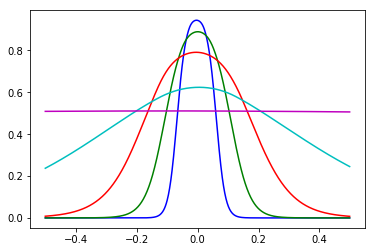

In [48]:
start =-0.5
xvals = []
while start < 0.5:
    xvals+=[start]
    start+=0.001
    pass
fig, ax = plt.subplots()
colors=['b','g','r','c','m']
for i in range(len(sigmas)):
    sigma = sigmas[i]
    NNoutput_s = models_si[sigma].predict(np.array(xvals))
    ax.plot(xvals, NNoutput_s,color=colors[i])

In [60]:
signal_input_output = {}
background_input_output = {}
for s in sigmas:
    
    print(s)
    
    for sigma in sigmas:

        signal_input_output[s,sigma] = models_si[sigma].predict(signal_tot_si[s])
        background_input_output[s,sigma] = models_si[sigma].predict(background_tot_si[s])

        print("   ",sigma,sum(signal_input_output[s,sigma])/sum(background_input_output[s,sigma])**0.5)

0.02
    0.02 [1759.2024]
    0.04 [1353.6669]
    0.08 [969.91394]
    0.16 [650.92456]
    0.32 [506.86252]
0.04
    0.02 [1355.2339]
    0.04 [1229.842]
    0.08 [944.1605]
    0.16 [643.29895]
    0.32 [506.84448]
0.08
    0.02 [811.0776]
    0.04 [902.1321]
    0.08 [829.691]
    0.16 [615.6192]
    0.32 [506.78976]
0.16
    0.02 [427.73032]
    0.04 [527.10925]
    0.08 [587.0744]
    0.16 [544.1865]
    0.32 [506.31378]
0.32
    0.02 [257.3879]
    0.04 [330.15494]
    0.08 [413.10535]
    0.16 [481.97412]
    0.32 [505.65036]


In [94]:
def makeSIC(sig,back):
    xs = []
    ys = []
    zs = []
    for i in range(20):
        myval = i*0.05
        mys = len(np.array([x for x in sig if x > myval]))
        myb = len(np.array([x for x in back if x > myval]))
        if (myb > 0):
            xs+=[mys/(1.*len(sig))]
            ys+=[(mys/(1.*len(sig)))/(myb/(1.*len(back)))**0.5]
            zs+=[myval]
            #print(myval,mys/(1.*len(sig)),(mys/(1.*len(sig)))/(myb/(1.*len(back)))**0.5)
            pass
    return [xs,ys,zs]

For one value of sigma, make an SIC curve and pick the value that maximizes it.  Then, see what happens if you pick the same fixed value for the wrong NN.

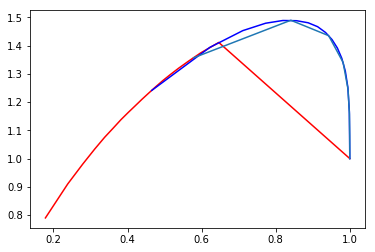

In [95]:
[x8,y8,z8] = makeSIC(signal_input_output[0.08,0.08],background_input_output[0.08,0.08])
[x2,y2,z2] = makeSIC(signal_input_output[0.08,0.02],background_input_output[0.08,0.02])
[x16,y16,z16] = makeSIC(signal_input_output[0.08,0.16],background_input_output[0.08,0.16])
plt.plot(x2,y2,color='r')
plt.plot(x8,y8,color='b')
plt.plot(x16,y16)

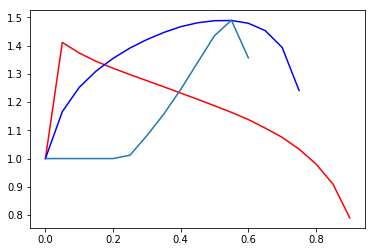

In [96]:
plt.plot(z2,y2,color='r')
plt.plot(z8,y8,color='b')
plt.plot(z16,y16)

Let's now suppose we have Nb background events and Ns signal events.  This is a counting experiment.  Under the background only hypothesis, we have Poisson(Nb) and we can compute the median significance of S+B.  Now, let's do the same thing where we weight each event.

In [189]:
myvals_spb = {}
myvals_b = {}
for sigma in [0.02,0.04,0.08,0.16,0.32]:
    for s in [0.02,0.04,0.08,0.16,0.32]:
        
        myweights = background_input_output[s,sigma][0:10000]
        myweights_s = signal_input_output[s,sigma][0:10000]
        myvals_spb[s,sigma] = []
        myvals_b[s,sigma] = []
        for i in range(10000):
            if (i%100==0):
                print(s,sigma,i/10000.)
                pass
            bootstrap = np.random.poisson(1,len(myweights))
            pseudodata = sum([a*b for a,b in zip(bootstrap,myweights)])
            bootstrap_s = np.random.poisson(1,len(myweights_s))
            pseudodata_s = sum([a*b for a,b in zip(bootstrap_s,myweights_s)])
            myvals_b[s,sigma]+=[pseudodata[0]]
            myvals_spb[s,sigma]+=[pseudodata[0]+0.005*pseudodata_s[0]]
            pass
        pass
    pass

0.02 0.02 0.0
0.02 0.02 0.01
0.02 0.02 0.02
0.02 0.02 0.03
0.02 0.02 0.04
0.02 0.02 0.05
0.02 0.02 0.06
0.02 0.02 0.07
0.02 0.02 0.08
0.02 0.02 0.09
0.02 0.02 0.1
0.02 0.02 0.11
0.02 0.02 0.12
0.02 0.02 0.13
0.02 0.02 0.14
0.02 0.02 0.15
0.02 0.02 0.16
0.02 0.02 0.17
0.02 0.02 0.18
0.02 0.02 0.19
0.02 0.02 0.2
0.02 0.02 0.21
0.02 0.02 0.22
0.02 0.02 0.23
0.02 0.02 0.24
0.02 0.02 0.25
0.02 0.02 0.26
0.02 0.02 0.27
0.02 0.02 0.28
0.02 0.02 0.29
0.02 0.02 0.3
0.02 0.02 0.31
0.02 0.02 0.32
0.02 0.02 0.33
0.02 0.02 0.34
0.02 0.02 0.35
0.02 0.02 0.36
0.02 0.02 0.37
0.02 0.02 0.38
0.02 0.02 0.39
0.02 0.02 0.4
0.02 0.02 0.41
0.02 0.02 0.42
0.02 0.02 0.43
0.02 0.02 0.44
0.02 0.02 0.45
0.02 0.02 0.46
0.02 0.02 0.47
0.02 0.02 0.48
0.02 0.02 0.49
0.02 0.02 0.5
0.02 0.02 0.51
0.02 0.02 0.52
0.02 0.02 0.53
0.02 0.02 0.54
0.02 0.02 0.55
0.02 0.02 0.56
0.02 0.02 0.57
0.02 0.02 0.58
0.02 0.02 0.59
0.02 0.02 0.6
0.02 0.02 0.61
0.02 0.02 0.62
0.02 0.02 0.63
0.02 0.02 0.64
0.02 0.02 0.65
0.02 0.02 0.66
0.

0.02 0.04 0.5
0.02 0.04 0.51
0.02 0.04 0.52
0.02 0.04 0.53
0.02 0.04 0.54
0.02 0.04 0.55
0.02 0.04 0.56
0.02 0.04 0.57
0.02 0.04 0.58
0.02 0.04 0.59
0.02 0.04 0.6
0.02 0.04 0.61
0.02 0.04 0.62
0.02 0.04 0.63
0.02 0.04 0.64
0.02 0.04 0.65
0.02 0.04 0.66
0.02 0.04 0.67
0.02 0.04 0.68
0.02 0.04 0.69
0.02 0.04 0.7
0.02 0.04 0.71
0.02 0.04 0.72
0.02 0.04 0.73
0.02 0.04 0.74
0.02 0.04 0.75
0.02 0.04 0.76
0.02 0.04 0.77
0.02 0.04 0.78
0.02 0.04 0.79
0.02 0.04 0.8
0.02 0.04 0.81
0.02 0.04 0.82
0.02 0.04 0.83
0.02 0.04 0.84
0.02 0.04 0.85
0.02 0.04 0.86
0.02 0.04 0.87
0.02 0.04 0.88
0.02 0.04 0.89
0.02 0.04 0.9
0.02 0.04 0.91
0.02 0.04 0.92
0.02 0.04 0.93
0.02 0.04 0.94
0.02 0.04 0.95
0.02 0.04 0.96
0.02 0.04 0.97
0.02 0.04 0.98
0.02 0.04 0.99
0.04 0.04 0.0
0.04 0.04 0.01
0.04 0.04 0.02
0.04 0.04 0.03
0.04 0.04 0.04
0.04 0.04 0.05
0.04 0.04 0.06
0.04 0.04 0.07
0.04 0.04 0.08
0.04 0.04 0.09
0.04 0.04 0.1
0.04 0.04 0.11
0.04 0.04 0.12
0.04 0.04 0.13
0.04 0.04 0.14
0.04 0.04 0.15
0.04 0.04 0.16
0.

0.04 0.08 0.0
0.04 0.08 0.01
0.04 0.08 0.02
0.04 0.08 0.03
0.04 0.08 0.04
0.04 0.08 0.05
0.04 0.08 0.06
0.04 0.08 0.07
0.04 0.08 0.08
0.04 0.08 0.09
0.04 0.08 0.1
0.04 0.08 0.11
0.04 0.08 0.12
0.04 0.08 0.13
0.04 0.08 0.14
0.04 0.08 0.15
0.04 0.08 0.16
0.04 0.08 0.17
0.04 0.08 0.18
0.04 0.08 0.19
0.04 0.08 0.2
0.04 0.08 0.21
0.04 0.08 0.22
0.04 0.08 0.23
0.04 0.08 0.24
0.04 0.08 0.25
0.04 0.08 0.26
0.04 0.08 0.27
0.04 0.08 0.28
0.04 0.08 0.29
0.04 0.08 0.3
0.04 0.08 0.31
0.04 0.08 0.32
0.04 0.08 0.33
0.04 0.08 0.34
0.04 0.08 0.35
0.04 0.08 0.36
0.04 0.08 0.37
0.04 0.08 0.38
0.04 0.08 0.39
0.04 0.08 0.4
0.04 0.08 0.41
0.04 0.08 0.42
0.04 0.08 0.43
0.04 0.08 0.44
0.04 0.08 0.45
0.04 0.08 0.46
0.04 0.08 0.47
0.04 0.08 0.48
0.04 0.08 0.49
0.04 0.08 0.5
0.04 0.08 0.51
0.04 0.08 0.52
0.04 0.08 0.53
0.04 0.08 0.54
0.04 0.08 0.55
0.04 0.08 0.56
0.04 0.08 0.57
0.04 0.08 0.58
0.04 0.08 0.59
0.04 0.08 0.6
0.04 0.08 0.61
0.04 0.08 0.62
0.04 0.08 0.63
0.04 0.08 0.64
0.04 0.08 0.65
0.04 0.08 0.66
0.

0.04 0.16 0.5
0.04 0.16 0.51
0.04 0.16 0.52
0.04 0.16 0.53
0.04 0.16 0.54
0.04 0.16 0.55
0.04 0.16 0.56
0.04 0.16 0.57
0.04 0.16 0.58
0.04 0.16 0.59
0.04 0.16 0.6
0.04 0.16 0.61
0.04 0.16 0.62
0.04 0.16 0.63
0.04 0.16 0.64
0.04 0.16 0.65
0.04 0.16 0.66
0.04 0.16 0.67
0.04 0.16 0.68
0.04 0.16 0.69
0.04 0.16 0.7
0.04 0.16 0.71
0.04 0.16 0.72
0.04 0.16 0.73
0.04 0.16 0.74
0.04 0.16 0.75
0.04 0.16 0.76
0.04 0.16 0.77
0.04 0.16 0.78
0.04 0.16 0.79
0.04 0.16 0.8
0.04 0.16 0.81
0.04 0.16 0.82
0.04 0.16 0.83
0.04 0.16 0.84
0.04 0.16 0.85
0.04 0.16 0.86
0.04 0.16 0.87
0.04 0.16 0.88
0.04 0.16 0.89
0.04 0.16 0.9
0.04 0.16 0.91
0.04 0.16 0.92
0.04 0.16 0.93
0.04 0.16 0.94
0.04 0.16 0.95
0.04 0.16 0.96
0.04 0.16 0.97
0.04 0.16 0.98
0.04 0.16 0.99
0.08 0.16 0.0
0.08 0.16 0.01
0.08 0.16 0.02
0.08 0.16 0.03
0.08 0.16 0.04
0.08 0.16 0.05
0.08 0.16 0.06
0.08 0.16 0.07
0.08 0.16 0.08
0.08 0.16 0.09
0.08 0.16 0.1
0.08 0.16 0.11
0.08 0.16 0.12
0.08 0.16 0.13
0.08 0.16 0.14
0.08 0.16 0.15
0.08 0.16 0.16
0.

0.08 0.32 0.0
0.08 0.32 0.01
0.08 0.32 0.02
0.08 0.32 0.03
0.08 0.32 0.04
0.08 0.32 0.05
0.08 0.32 0.06
0.08 0.32 0.07
0.08 0.32 0.08
0.08 0.32 0.09
0.08 0.32 0.1
0.08 0.32 0.11
0.08 0.32 0.12
0.08 0.32 0.13
0.08 0.32 0.14
0.08 0.32 0.15
0.08 0.32 0.16
0.08 0.32 0.17
0.08 0.32 0.18
0.08 0.32 0.19
0.08 0.32 0.2
0.08 0.32 0.21
0.08 0.32 0.22
0.08 0.32 0.23
0.08 0.32 0.24
0.08 0.32 0.25
0.08 0.32 0.26
0.08 0.32 0.27
0.08 0.32 0.28
0.08 0.32 0.29
0.08 0.32 0.3
0.08 0.32 0.31
0.08 0.32 0.32
0.08 0.32 0.33
0.08 0.32 0.34
0.08 0.32 0.35
0.08 0.32 0.36
0.08 0.32 0.37
0.08 0.32 0.38
0.08 0.32 0.39
0.08 0.32 0.4
0.08 0.32 0.41
0.08 0.32 0.42
0.08 0.32 0.43
0.08 0.32 0.44
0.08 0.32 0.45
0.08 0.32 0.46
0.08 0.32 0.47
0.08 0.32 0.48
0.08 0.32 0.49
0.08 0.32 0.5
0.08 0.32 0.51
0.08 0.32 0.52
0.08 0.32 0.53
0.08 0.32 0.54
0.08 0.32 0.55
0.08 0.32 0.56
0.08 0.32 0.57
0.08 0.32 0.58
0.08 0.32 0.59
0.08 0.32 0.6
0.08 0.32 0.61
0.08 0.32 0.62
0.08 0.32 0.63
0.08 0.32 0.64
0.08 0.32 0.65
0.08 0.32 0.66
0.

In [ ]:
plt.hist(myvals_b[0.02,0.04],alpha=0.5,color='b',bins=20)
plt.hist(myvals_spb[0.02,0.04],alpha=0.5,color='r',bins=20)

In [194]:
for sigma in [0.02,0.04,0.08,0.16,0.32]:
    for s in [0.32]: #,0.04]:
        cutvalup = max(myvals_b[s,sigma])
        cutvaldn = min(myvals_b[s,sigma])
        while (cutvalup-cutvaldn > 1):
            cutval = 0.5*(cutvalup+cutvaldn)
            myval = len([a for a in myvals_b[s,sigma] if a > cutval])/(1.*len(myvals_b[s,sigma]))
            if (myval <= 0.05):
                cutvalup = cutval
            else:
                cutvaldn = cutval
            pass
        print(s,sigma,len([a for a in myvals_b[s,sigma] if a > cutval])/(1.*len(myvals_b[s,sigma])),len([a for a in myvals_spb[s,sigma] if a > cutval])/(1.*len(myvals_spb[s,sigma])))

0.32 0.02 0.0496 0.0749
0.32 0.04 0.049 0.0863
0.32 0.08 0.0508 0.1028
0.32 0.16 0.05 0.1263
0.32 0.32 0.0505 0.1269


500000